# Problem Statement:

## The dataset is provided with total energy demand on an hourly basis for the past 9 years from March 2008 to Dec 2018 in the training set. You need to forecast the total energy demand on an hourly basis for the next 3 years from 2019 to 2021 in the test set.

In [22]:
# import the required libraries

import numpy as np
import pandas as pd
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings('ignore')

In [43]:
# Importing the Dataset 

train_df = pd.read_csv('train_data.csv')
test_df = pd.read_csv('test_data.csv')

In [44]:
train_df.head(2)

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500


## Data Insights and EDA

In [45]:
# Printing the shape of the train and test dataset

print(train_df.shape)
print(test_df.shape)

(94992, 3)
(26304, 2)


In [46]:
# View the summary of the dataset

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row_id    94992 non-null  int64  
 1   datetime  94992 non-null  object 
 2   energy    93092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


Comment:
- The datetime column is of object type which needs to be changed to Datetime datatype.
- There are some null values present in energy column. Let's check that.

In [47]:
# let's check if the data has any missing values:

train_df.isnull().sum()/ train_df.shape[0]*100

row_id      0.000000
datetime    0.000000
energy      2.000168
dtype: float64

Comment:
- Since there are only 2% of missing values so we can drop the null values.

In [48]:
train_df.dropna(inplace=True)

In [49]:
row_id = test_df['row_id']

train_df.drop(columns=['row_id'],axis=1,inplace=True)
test_df.drop(columns=['row_id'],axis=1,inplace=True)

In [50]:
# Changing the datetime column datatype to Datetime 

train_df['datetime']= pd.to_datetime(train_df['datetime'])
test_df['datetime']= pd.to_datetime(test_df['datetime'])

In [51]:
train_df.head(2)

,datetime,energy
0,2008-03-01 00:00:00,1259.985563
1,2008-03-01 01:00:00,1095.541500


In [52]:
test_df.head(2)

,datetime
0,2019-01-01 00:00:00
1,2019-01-01 01:00:00


In [53]:
# Set the datetime column as index 

train_df.set_index('datetime', drop= True, inplace= True)
test_df.set_index('datetime', drop= True, inplace=True)

## Visualizing the time series data

<AxesSubplot:xlabel='datetime'>

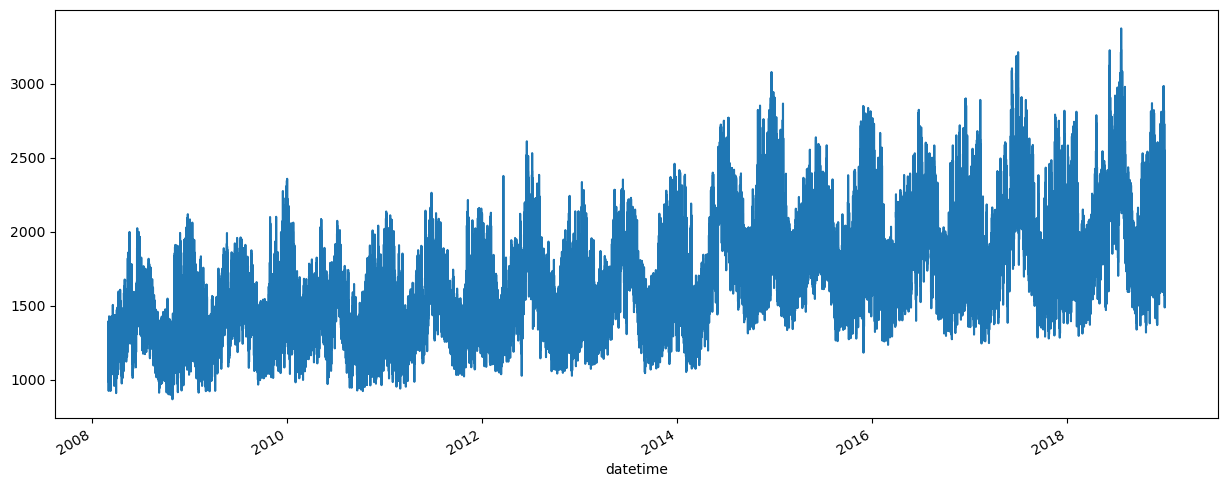

In [54]:
train_df['energy'].plot()

## Check the Stationarity of the data

In [55]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=8544,center=False).mean() 
    rolstd = timeseries.rolling(window=8544,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

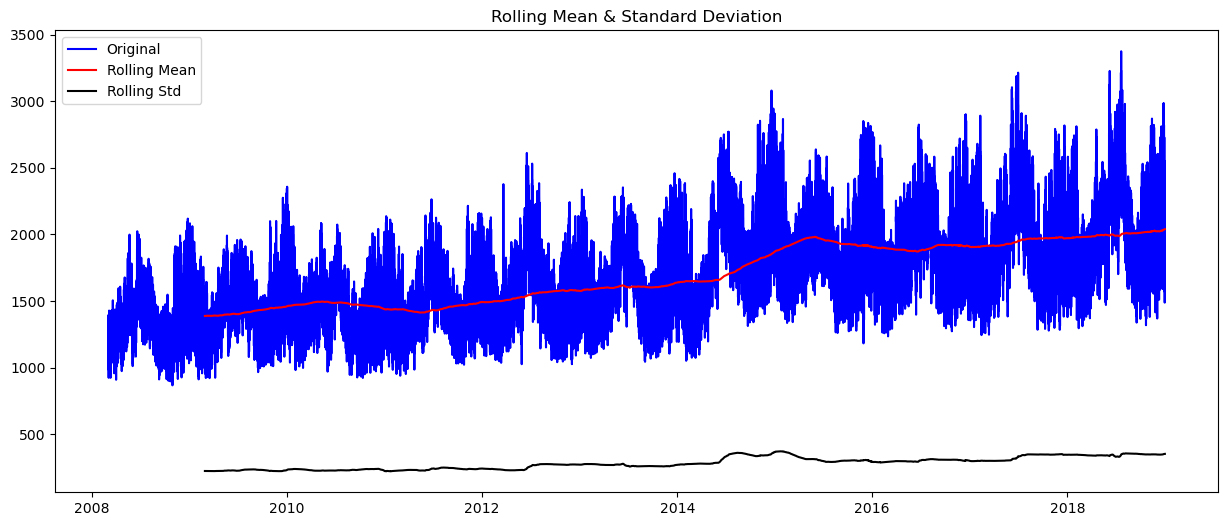

Results of Dickey-Fuller Test:
Test Statistic                -9.527076e+00
p-value                        2.958121e-16
#Lags Used                     6.700000e+01
Number of Observations Used    9.302400e+04
Critical Value (1%)           -3.430420e+00
Critical Value (5%)           -2.861571e+00
Critical Value (10%)          -2.566787e+00
dtype: float64


In [56]:
test_stationarity(train_df['energy'])

We could see the data is stationary as the p-value is less than 0.05, so we will go ahead with model building

## Model Building

In [77]:
model_SARIMA=SARIMAX(train_df['energy'],
                     order=(3,0,2),
                     seasonal_order=(0,1,0,12),
                     enforce_stationarity=False,
                    enforce_invertibility=False)

In [78]:
model_SARIMA_fit=model_SARIMA.fit()

In [79]:
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              energy   No. Observations:                93092
Model:             SARIMAX(3, 0, 2)x(0, 1, [], 12)   Log Likelihood             -487375.699
Date:                             Thu, 24 Nov 2022   AIC                         974763.398
Time:                                     19:07:16   BIC                         974820.045
Sample:                                          0   HQIC                        974780.645
                                           - 93092                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7595      0.008    210.275      0.000       1.743       1.776
ar.L2         -0.6927      0.016    -43.674      0.000      -0.724      -0.662
ar.L3         -0.1428      0.008    -17.599      0.000      -0.159      -0.127
ma.L1         -0.8099      0.005   -151.748      0.000      -0.820      -0.799
ma.L2         -0.6576      0.010    -68.049      0.000      -0.677      -0.639
sigma2      1204.2431      8.179    147.227      0.000    1188.212    1220.275
===================================================================================
Ljung-Box (L1) (Q):                  74.99   Jarque-Bera (JB):           1723187.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.70   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
y_pred = model_SARIMA_fit.forecast(26304)

In [81]:
y_pred[:20]

93092    2033.953172
93093    1899.890060
93094    1764.365508
93095    1648.997429
93096    1575.682493
93097    1543.328906
93098    1575.573639
93099    1610.867304
93100    1658.148295
93101    1726.254278
93102    1905.108825
93103    1967.783088
93104    2054.831211
93105    2146.315259
93106    2213.837474
93107    2266.174954
93108    2315.076909
93109    2352.596264
93110    2399.171142
93111    2393.821727
Name: predicted_mean, dtype: float64

## Submission

In [63]:
submission = pd.DataFrame()
submission['row_id'] = row_id
submission['energy'] = y_pred

In [64]:
submission

,row_id,energy
0,94993,2033.953172
1,94994,1899.890060
2,94995,1764.365508
3,94996,1648.997429
4,94997,1575.682493
...,...,...
26299,121292,2033.416954
26300,121293,2029.950335
26301,121294,2024.056827
26302,121295,2111.200083


In [111]:
submission.to_csv('submission.csv', index= None)

## Conclusion:
    
- I tried with different alogithms like ARIMA, SARIMAX, XGBOOST regressor. But Sarimax performs better than others.